In [1]:
## Importing the libraries 
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from ipywidgets import interact

In [2]:
#data = pd.read_csv("./Crop_recommendation.csv")
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_90929f753e7f4f11a97214420fc3c922 = 'https://s3.eu.cloud-object-storage.appdomain.cloud'
else:
    endpoint_90929f753e7f4f11a97214420fc3c922 = 'https://s3.private.eu.cloud-object-storage.appdomain.cloud'

client_90929f753e7f4f11a97214420fc3c922 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='kyOT4vM1ouRf95OHXkNCs2Jlon_JEjsHlier_naXuc8m',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_90929f753e7f4f11a97214420fc3c922)

body = client_90929f753e7f4f11a97214420fc3c922.get_object(Bucket='croprecommendation-donotdelete-pr-djkzfc7y0zl1ty',Key='Crop_recommendation.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
data.head()


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [5]:
data.corr()

,N,P,K,temperature,humidity,ph,rainfall
N,1.000000,-0.231460,-0.140512,0.026504,0.190688,0.096683,0.059020
P,-0.231460,1.000000,0.736232,-0.127541,-0.118734,-0.138019,-0.063839
K,-0.140512,0.736232,1.000000,-0.160387,0.190859,-0.169503,-0.053461
temperature,0.026504,-0.127541,-0.160387,1.000000,0.205320,-0.017795,-0.030084
humidity,0.190688,-0.118734,0.190859,0.205320,1.000000,-0.008483,0.094423
ph,0.096683,-0.138019,-0.169503,-0.017795,-0.008483,1.000000,-0.109069
rainfall,0.059020,-0.063839,-0.053461,-0.030084,0.094423,-0.109069,1.000000


In [6]:
data.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')

In [7]:
#To get the list of crops that can be predicted by the data set
crops = set(data['label'].values)
crops

{'apple',
 'banana',
 'blackgram',
 'chickpea',
 'coconut',
 'coffee',
 'cotton',
 'grapes',
 'jute',
 'kidneybeans',
 'lentil',
 'maize',
 'mango',
 'mothbeans',
 'mungbean',
 'muskmelon',
 'orange',
 'papaya',
 'pigeonpeas',
 'pomegranate',
 'rice',
 'watermelon'}

In [8]:
data.shape

(2200, 8)

In [9]:
data.describe()


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [10]:
from sklearn.preprocessing import LabelEncoder
crop_encoder = LabelEncoder()
data["crop_encoded"] = crop_encoder.fit_transform(data['label'])

In [11]:
data

,N,P,K,temperature,humidity,ph,rainfall,label,crop_encoded
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,20
...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee,5
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee,5
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee,5
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee,5


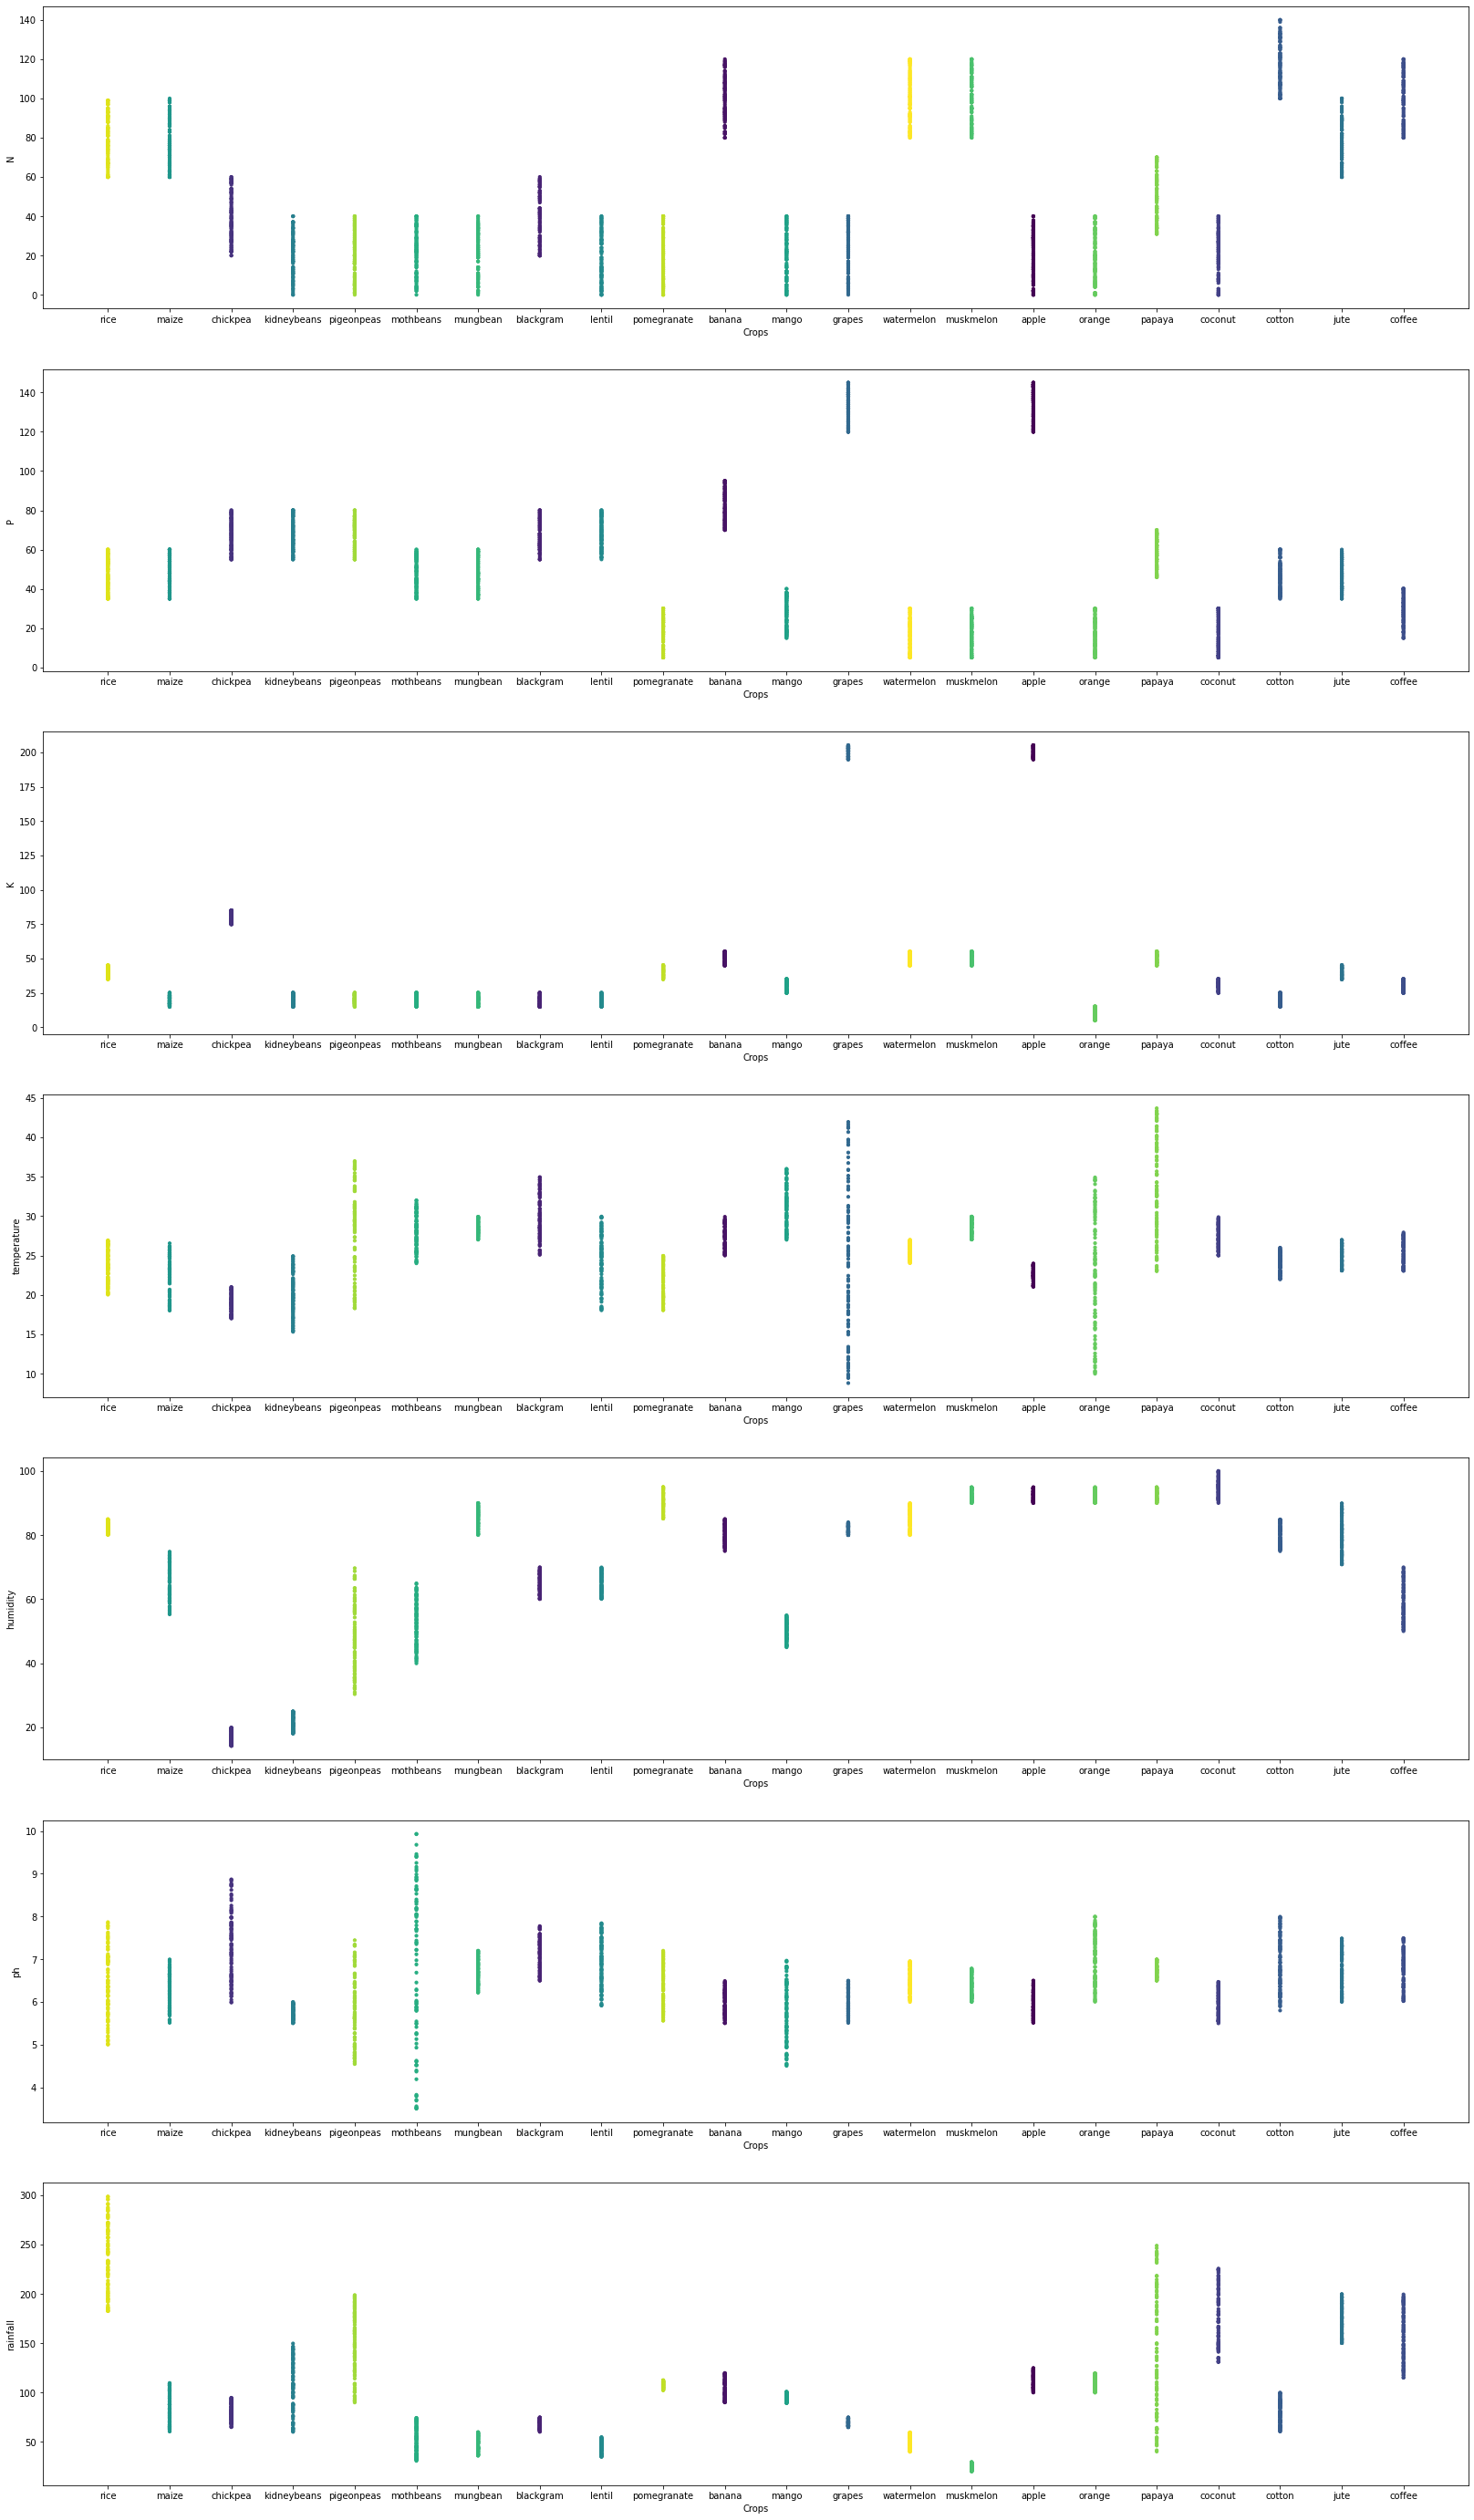

In [12]:
number_of_columns = 7
fig,ax = plt.subplots(number_of_columns,1,figsize=(28,50))
for ind,col in enumerate(data.columns[:7]):
    ax[ind].scatter(data['label'],data[col],s=10,c=data['crop_encoded'])
    ax[ind].set_xlabel("Crops")
    ax[ind].set_ylabel(col)

In [13]:
###Choosing the Dependent and Independent variables
# Independent Variables
x=data.iloc[:,[0,1,2,3,4,5,6]]
x

,N,P,K,temperature,humidity,ph,rainfall
0,90,42,43,20.879744,82.002744,6.502985,202.935536
1,85,58,41,21.770462,80.319644,7.038096,226.655537
2,60,55,44,23.004459,82.320763,7.840207,263.964248
3,74,35,40,26.491096,80.158363,6.980401,242.864034
4,78,42,42,20.130175,81.604873,7.628473,262.717340
...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507
2196,99,15,27,27.417112,56.636362,6.086922,127.924610
2197,118,33,30,24.131797,67.225123,6.362608,173.322839
2198,117,32,34,26.272418,52.127394,6.758793,127.175293


In [14]:
# Dependent Variable(target column)
y=data.iloc[:,8]
y

0       20
1       20
2       20
3       20
4       20
        ..
2195     5
2196     5
2197     5
2198     5
2199     5
Name: crop_encoded, Length: 2200, dtype: int64

In [15]:
## TRAIN TEST SPLIT

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)


In [16]:
## FEATURE SCALING

from sklearn.preprocessing import MinMaxScaler

sc=MinMaxScaler()


In [17]:
x_train

,N,P,K,temperature,humidity,ph,rainfall
1567,27,120,200,21.452787,90.745319,6.110219,116.703658
2031,81,36,38,23.765547,87.983299,6.334838,150.316615
2073,90,59,35,24.251335,89.864541,7.098228,175.174211
1374,81,16,45,26.904357,86.254262,6.727468,59.759800
279,47,80,77,17.182484,16.428918,7.561108,72.850173
...,...,...,...,...,...,...,...
1033,102,71,48,28.654563,79.286937,5.695268,102.463378
1731,34,68,51,27.347349,94.177567,6.687088,40.351531
763,35,64,15,28.474423,63.536045,6.500145,69.527441
835,39,65,23,25.434598,69.126134,7.685959,41.026829


In [18]:
x_train=sc.fit_transform(x_train)

In [19]:
x_train

array([[0.19285714, 0.82142857, 0.975     , ..., 0.89225218, 0.40327048,
        0.3463106 ],
       [0.57857143, 0.22142857, 0.165     , ..., 0.8600322 , 0.43831396,
        0.46713355],
       [0.64285714, 0.38571429, 0.15      , ..., 0.88197757, 0.55741269,
        0.55648505],
       ...,
       [0.25      , 0.42142857, 0.05      , ..., 0.574846  , 0.464104  ,
        0.17673404],
       [0.27857143, 0.42857143, 0.09      , ..., 0.64005645, 0.64910639,
        0.0742876 ],
       [0.1       , 0.12142857, 0.02      , ..., 0.89682976, 0.47081987,
        0.33123294]])

In [20]:
x_test=sc.transform(x_test)

x_test

array([[0.75      , 0.06428571, 0.225     , ..., 0.85659207, 0.45145248,
        0.14125047],
       [0.65      , 0.05      , 0.205     , ..., 0.83105639, 0.4397344 ,
        0.10047508],
       [0.1       , 0.82857143, 0.99      , ..., 0.81062187, 0.41083252,
        0.19447908],
       ...,
       [0.83571429, 0.36428571, 0.05      , ..., 0.73254205, 0.59954091,
        0.24715594],
       [0.19285714, 0.42142857, 0.08      , ..., 0.63489897, 0.62692836,
        0.19163059],
       [0.22142857, 0.89285714, 0.965     , ..., 0.91545631, 0.31662163,
        0.3583703 ]])

In [21]:
## MODEL BUILDING
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state=0)
lr.fit(x_train,y_train)

LogisticRegression(random_state=0)

In [22]:
y_pred=lr.predict(x_test)
#y_pred

0.9048051945895694


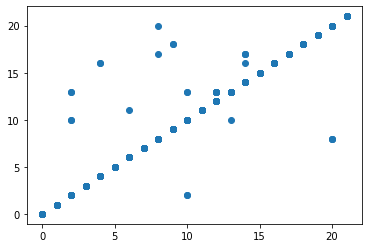

In [23]:
## Testing for Accuracy
print(r2_score(y_test,y_pred))
plt.scatter(y_pred,y_test)

In [24]:
print(data.iloc[0])
currentData = [[90,42,43,20.8,82.00,6,202.9]]

N                       90
P                       42
K                       43
temperature      20.879744
humidity         82.002744
ph                6.502985
rainfall        202.935536
label                 rice
crop_encoded            20
Name: 0, dtype: object


In [25]:
sc.transform(currentData)

array([[0.64285714, 0.26428571, 0.19      , 0.34359792, 0.79023482,
        0.38607492, 0.65614637]])

In [26]:
lr.predict(currentData)

array([20])

In [27]:
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label,crop_encoded
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,20


1 neighbours has score 0.9417082751194498
2 neighbours has score 0.9416285333556413
3 neighbours has score 0.9541808935740904
4 neighbours has score 0.9527172036614397
5 neighbours has score 0.9526104013120199
6 neighbours has score 0.9486693599451411
7 neighbours has score 0.9472973431605665
8 neighbours has score 0.9449769737906719
9 neighbours has score 0.9393080917552322
10 neighbours has score 0.9376050406400047


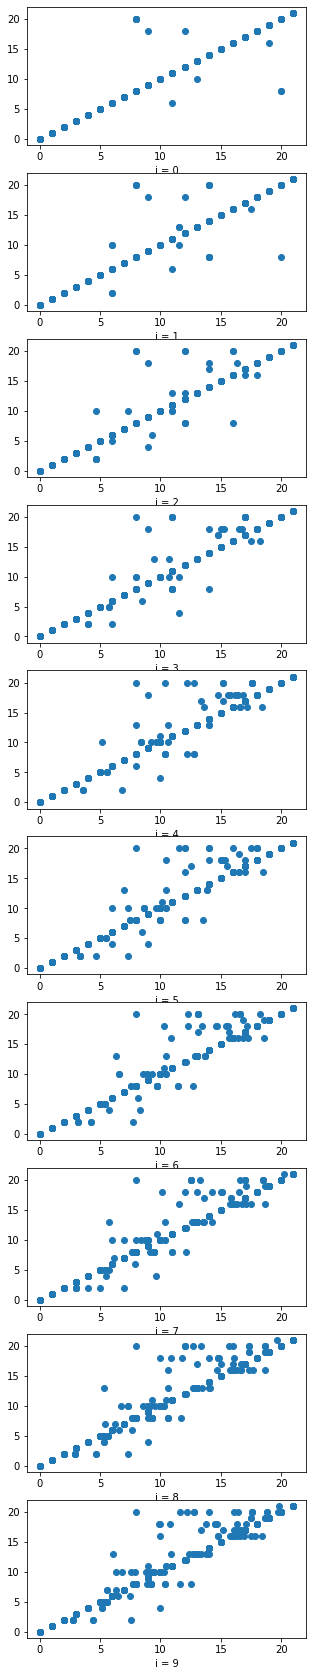

In [28]:
fig,ax = plt.subplots(10,1,figsize=(5,30))
for i in range(10):
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("model", KNeighborsRegressor(n_neighbors=i+1))
    ])
    pred = pipe.fit(x_train,y_train).predict(x_test)
    print(str(i+1)+" neighbours has score "+str(r2_score(pred,y_test)))
    ax[i].scatter(pred, y_test)
    ax[i].set_xlabel("i = "+str(i))

In [29]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", KNeighborsRegressor(n_neighbors=3))
])
pred = pipe.fit(x_train,y_train)

In [30]:
pred.predict(currentData)

array([20.])

In [31]:
crop_encoder.inverse_transform([20])

array(['rice'], dtype=object)

# Deployment of our model

In [32]:
!pip install ibm_watson_machine_learning

In [40]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
    "url":"https://eu-gb.ml.cloud.ibm.com",
    "apikey":"B1mo3gmGszh2wXROK6WnFupr8N8bSqXpkm1nJoVhMR_5"
}
client = APIClient(wml_credentials)

In [43]:
def guid_from_space_name(client,space_name):
    space = client.spaces.get_details()
    #print(space)
    return (next(item for item in space['resources'] if item['entity']['name'] == space_name)['metadata']['id'])

In [44]:
space_uid = guid_from_space_name(client,'crop_recommendation_space')
print(space_uid)

42276491-9423-40da-bedc-ec59d9bb5dbe


In [45]:
client.set.default_space(space_uid)

'SUCCESS'

In [46]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
scikit-learn_0.22-py3.6        154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                   1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
pytorch-onnx_1.3-py3.6         1bc6029

In [54]:
software_spec_uid = client.software_specifications.get_uid_by_name("default_py3.8")
software_spec_uid

'ab9e1b80-f2ce-592c-a7d2-4f2344f77194'

In [55]:
model_details = client.repository.store_model(model=pipe,
            meta_props={
                client.repository.ModelMetaNames.NAME:"model-001",
                client.repository.ModelMetaNames.TYPE:"scikit-learn_0.23",
                client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
            }
     )
model_id = client.repository.get_model_uid(model_details)

In [56]:
model_id

'8ed80253-5690-4580-bd46-82acfcd127a1'